In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install category_encoders
# !pip install dacon_submit_api-0.0.4-py3-none-any.whl
# !pip install mljar-supervised

In [3]:
## import 
import pandas as pd
import numpy as np
from supervised.automl import AutoML

# vis
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치. 코랩에선 주석하셈
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor 
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.base import ClassifierMixin
# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error

# CatBoost
from catboost import CatBoostRegressor

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
# import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import holidays

# 시드값 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(2023)

# 데이터프레임 컬럼 전체 보기
pd.set_option('display.max_columns', None)

In [4]:
# 데이터 로드

path = '../data/daegu/automl/'

train_org = pd.read_csv(path+'train.csv')
test_org = pd.read_csv(path+'test.csv')

In [5]:
# 이희원님 코드 그대로 사용
for df in [train_org, test_org]:
    # 날짜 데이터
    time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

    df[['연', '월', '일', '시간']] = df['사고일시'].str.extract(time_pattern)
    df[['연', '월', '일', '시간']] = df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
    df['사고일시'] = pd.to_datetime(df['사고일시'])
    # df= df.drop(columns=['사고일시']) # 일단 냄겨두자

    # 도시/구/동 분리
    location_pattern = r'(\S+) (\S+) (\S+)'

    df[['도시', '구', '동']] = df['시군구'].str.extract(location_pattern)
    # df= df.drop(columns=['시군구']) # 얘도 일단 냄겨놔

    # 도로형태도 분류 코드
    #road_pattern = r'(.+) - (.+)'

    #df[['도로형태1', '도로형태2']] = df['도로형태'].str.extract(road_pattern)
    #df= df.drop(columns=['도로형태']) # 얘는 드롭함

    # 시간 >> 코사인 변환
#     df['cos_hour'] = np.cos(2 * np.pi * df['시간'] / 24)
    # 📢송규헌) 사인-코사인 변환
    df['cos_hour'] = np.sign(np.pi*2*df['시간']/24) + np.cos(np.pi*2*df['시간']/24) + np.sign(np.pi*4*df['시간']/24) + np.cos(np.pi*4*df['시간']/24)

    # 월 >> 코사인 변환
#     df['cos_month'] = -np.cos(np.pi*2*df['월']/12) + np.cos(np.pi*2*df['월']/12) - np.cos(np.pi*4*df['월']/12) + np.sign(np.pi*5*df['월']/12) + np.cos(np.pi*1*df['월']/12) + 2

    
    # 공휴일 (주말과 공휴일을 묶음)
    # 공휴일 = 1, 비공휴일 = 0
    holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']
    df['dow'] = df['사고일시'].dt.dayofweek #임시로 만든 컬럼
    df['holiday'] = np.where((df['dow']>=5) | (df['사고일시'].dt.strftime('%Y-%m-%d').isin(holi_weekday)),1,0)
    df.drop('dow',axis=1,inplace=True)
    
    # 계절 >> cos_month 사용할 때는 season은 생략
    def group_season(df):
        df.loc[(df['월'] == 3) | (df['월'] == 4) | (df['월'] == 5), 'season'] = '봄'
        df.loc[(df['월'] == 6) | (df['월'] == 7) | (df['월'] == 8), 'season'] = '여름'
        df.loc[(df['월'] == 9) | (df['월'] == 10) | (df['월'] == 11), 'season'] = '가을'
        df.loc[(df['월'] == 12) | (df['월'] == 1) | (df['월'] == 2), 'season'] = '겨울'
        return df['season']
    df['season'] = group_season(df)

In [6]:
train_df = train_org
test_df = test_org

In [7]:
# load data
light_df = pd.read_csv(path+'동별_보안등개수.csv').rename(columns={'설치개수':'보안등개수'})
parking_df = pd.read_csv(path+'주차장급지구분별개수.csv')
speed_df = pd.read_csv(path+'동별_제한속도_2.csv').drop(columns='Unnamed: 0')
cross_walk_df = pd.read_csv(path+'동별_횡단보도개수.csv')
child_area_df = pd.read_csv(path+'동별_어린이보호구역개수_2.csv').rename(columns={'시설종류':'어린이보호구역개수'})


# merge data
train_df = pd.merge(train_df, light_df, how='left', on=['구','동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['구','동'])
train_df = pd.merge(train_df, speed_df, how='left', on='동')
train_df = pd.merge(train_df, cross_walk_df, how='left', on='동')
train_df = pd.merge(train_df, child_area_df, how='left', on=['동'])

test_df = pd.merge(test_df, light_df, how='left', on=['구','동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['구','동'])
test_df = pd.merge(test_df, speed_df, how='left', on='동')
test_df = pd.merge(test_df, cross_walk_df, how='left', on='동')
test_df = pd.merge(test_df, child_area_df, how='left', on=['동'])


In [8]:
### 피처 추가...

# 시군구별 사고횟수 >> 기본 코드 사용
accident_counts = train_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옵니다.
train_df['사고발생횟수'] = train_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])
test_df['사고발생횟수'] = test_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])




In [9]:
###⚠️연도 그냥 타겟 인코딩할래
# # 📢송규헌) 연도값을 연도별 eclo평균값으로 변경
# # 선형추세
# yearly_eclo_avg = train_df.groupby('연')['ECLO'].mean()
# x = np.array(yearly_eclo_avg.index)
# y = yearly_eclo_avg.values
# lr = LinearRegression()
# lr.fit(x.reshape(-1,1),y.reshape(-1,1))
# pred = lr.predict(np.array([2022]).reshape(-1,1))
# yearly_eclo_avg[2022] = pred.reshape(1)[0]

# train_df['연'] =  train_df['연'].map(yearly_eclo_avg)
# test_df['연'] =  test_df['연'].map(yearly_eclo_avg)

In [10]:
# 점검
display(train_df.head(2))
display(test_df.head(2))

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,cos_hour,holiday,season,보안등개수,급지구분_1,급지구분_2,급지구분_3,제한속도,횡단보도개수,어린이보호구역개수,사고발생횟수
0,ACCIDENT_00000,2019-01-01,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,2019,1,1,0,대구광역시,중구,대신동,2.0,1,겨울,391.0,11.0,0.0,0.0,8.0,5929.0,2.0,131
1,ACCIDENT_00001,2019-01-01,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,2019,1,1,0,대구광역시,달서구,감삼동,2.0,1,겨울,941.0,0.0,1.0,3.0,17.5,10000.0,NaN,678


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,연,월,일,시간,도시,구,동,cos_hour,holiday,season,보안등개수,급지구분_1,급지구분_2,급지구분_3,제한속도,횡단보도개수,어린이보호구역개수,사고발생횟수
0,ACCIDENT_39609,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,3.831951,1,겨울,700.0,NaN,NaN,NaN,52.500000,9025.0,5.0,338
1,ACCIDENT_39610,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,3.831951,1,겨울,NaN,0.0,0.0,2.0,47.142857,52441.0,10.0,492


In [11]:
# 불필요 컬럼 제거
drop_columns = ['ID','도시','시간','시군구','사고일시','사고유형 - 세부분류','법규위반','가해운전자 차종','가해운전자 성별','가해운전자 연령',
       '가해운전자 상해정도','사망자수','중상자수','피해운전자 차종','피해운전자 성별',
      '피해운전자 연령','피해운전자 상해정도','경상자수','부상자수'
]
train_df.drop(columns = drop_columns,inplace=True)
test_df.drop(columns=['ID','도시','시간','사고일시','시군구'
                     
                     
                     
                     ],inplace=True)

### 이상치 처리 및 결측값 처리

In [12]:
# 결측값 확인 
train_df.isnull().sum().sort_values(ascending=False)[:11]

보안등개수        13813
어린이보호구역개수    12967
급지구분_3        6543
급지구분_2        6543
급지구분_1        6543
제한속도          1498
횡단보도개수          62
요일               0
기상상태             0
season           0
holiday          0
dtype: int64

In [13]:
test_df.isnull().sum().sort_values(ascending=False)[:11]

보안등개수        4029
어린이보호구역개수    3430
급지구분_3       1928
급지구분_2       1928
급지구분_1       1928
제한속도          434
횡단보도개수         21
요일              0
holiday         0
season          0
cos_hour        0
dtype: int64

In [14]:
# # 일단 interpolate
# for df in [train_df,test_df]:
#     df['어린이보호구역개수'] = df['어린이보호구역개수'].interpolate()
#     df['급지구분_1'] = df['급지구분_1'].interpolate()
#     df['급지구분_2'] = df['급지구분_2'].interpolate()
#     df['급지구분_3'] = df['급지구분_3'].interpolate()
#     df['제한속도'] = df['제한속도'].interpolate()
#     df['횡단보도개수'] = df['횡단보도개수'].interpolate()
    
# # 급지구분 interpolate하면 안 채워지는 게 1개 있어서 0으로 대체
# test_df['급지구분_1'] = test_df['급지구분_1'].fillna(0)
# test_df['급지구분_2'] = test_df['급지구분_2'].fillna(0)
# test_df['급지구분_3'] = test_df['급지구분_3'].fillna(0)

In [15]:
# 결측값을 '구' 별 평균으로 처리
na_columns = ['어린이보호구역개수','급지구분_1','급지구분_1','급지구분_1'
             ,'제한속도','횡단보도개수','보안등개수']


### 어린이보호구역개수 결측값 처리
child_area_mean = train_df.groupby('구')['어린이보호구역개수'].mean()
# 달서구와 동구가 아예 어린이보호구역개수가 nan임.
child_mean_sum = child_area_mean.sum()/len(child_area_mean)
# 전체평균으로 대체 # 동구와 달성군 모두 면적이 넓음
child_area_mean['달서구'] = child_mean_sum
child_area_mean['동구'] = child_mean_sum
def fillna_with_mean_child(row):
    if np.isnan(row['어린이보호구역개수']):
        row['어린이보호구역개수'] = child_area_mean[row['구']]
    return row
train_df = train_df.apply(fillna_with_mean_child,axis=1)
test_df = test_df.apply(fillna_with_mean_child,axis=1)


### 급지구분 결측값 처리
parking_mean = train_df.groupby('구')[['급지구분_1','급지구분_2',
                          '급지구분_3']].mean()
cols = ['급지구분_1','급지구분_2','급지구분_3']
for col in cols:
    def fillna_with_mean_parking(row):
        if np.isnan(row[col]):
            row[col] = parking_mean.loc[row['구'],col]
        return row
    train_df = train_df.apply(fillna_with_mean_parking,axis=1)
    test_df = test_df.apply(fillna_with_mean_parking,axis=1)
### 급지구분_1,2,3 컬럼을 주차장지수로 변경 >> 1급지*4 + 2급지*2 + 3급지
# train_df['주차장지수'] = train_df['급지구분_1']*4+train_df['급지구분_2']*2+train_df['급지구분_3']
# test_df['주차장지수'] = test_df['급지구분_1']*4+test_df['급지구분_2']*2+test_df['급지구분_3']    
# train_df.drop(columns=['급지구분_1','급지구분_2','급지구분_3'],inplace=True)
# test_df.drop(columns=['급지구분_1','급지구분_2','급지구분_3'],inplace=True)
    

### 보안등개수 결측값 처리
light_mean = train_df.groupby('구')['보안등개수'].mean()
# 달성군과 서구가 NaN >> 달성군은 면적이 크므로 전체평균값을 활용, 
# 서구는 작으므로 Q1 사용
light_total_mean = light_mean.sum()/len(light_mean)
light_mean['달성군'] = light_total_mean
light_mean['서구'] = light_total_mean * 0.25
def fillna_with_mean_light(row):
    if np.isnan(row['보안등개수']):
        row['보안등개수'] = light_mean[row['구']]
    return row
train_df = train_df.apply(fillna_with_mean_light,axis=1)
test_df = test_df.apply(fillna_with_mean_light,axis=1)

 
### 제한속도 결측값 처리
speed_mean = train_df.groupby('구')['제한속도'].mean()
def fillna_with_mean_speed(row):
    if np.isnan(row['제한속도']):
        row['제한속도'] = speed_mean[row['구']]
    return row
train_df = train_df.apply(fillna_with_mean_speed,axis=1)
test_df = test_df.apply(fillna_with_mean_speed,axis=1)


### 횡단보도개수 결측값 처리
# cross_mean = train_df.groupby('구')['횡단보도개수'].mean()
# def fillna_with_mean_cross(row):
#     if np.isnan(row['횡단보도개수']):
#         row['횡단보도개수'] = cross_mean[row['구']]
#     return row
# train_df = train_df.apply(fillna_with_mean_cross,axis=1)
# test_df = test_df.apply(fillna_with_mean_cross,axis=1)
bookgu_cross = train_df[train_df['구']=='북구']['횡단보도개수'].mean()
donggu_cross = train_df[train_df['구']=='동구']['횡단보도개수'].mean()
junggu_cross = train_df[train_df['구']=='중구']['횡단보도개수'].mean()

cross_dict = {'중구': junggu_cross, '동구': donggu_cross, '북구': bookgu_cross}

for i in ['중구', '동구', '북구']:
    train_df.loc[(train_df['구']==i) & (train_df['횡단보도개수'].isnull()), '횡단보도개수'] = cross_dict[i]
    test_df.loc[(test_df['구']==i) & (test_df['횡단보도개수'].isnull()), '횡단보도개수'] = cross_dict[i]


In [16]:
# 연습용 코드

# ### 제한속도 결측값 처리
# cross_mean = train_df.groupby('구')['횡단보도개수'].mean()
# def fillna_with_mean_speed(row):
#     if np.isnan(row['횡단보도개수']):
#         row['횡단보도개수'] = light_mean[row['구']]
#     return row
# train_df = train_df.apply(fillna_with_mean_speed,axis=1)
# test_df = test_df.apply(fillna_with_mean_speed,axis=1)



In [17]:
# 결측값 확인 
train_df.isnull().sum().sort_values(ascending=False)[:5]," ---- " , test_df.isnull().sum().sort_values(ascending=False)[:5]

(요일           0
 기상상태         0
 어린이보호구역개수    0
 횡단보도개수       0
 제한속도         0
 dtype: int64,
 ' ---- ',
 요일           0
 holiday      0
 어린이보호구역개수    0
 횡단보도개수       0
 제한속도         0
 dtype: int64)

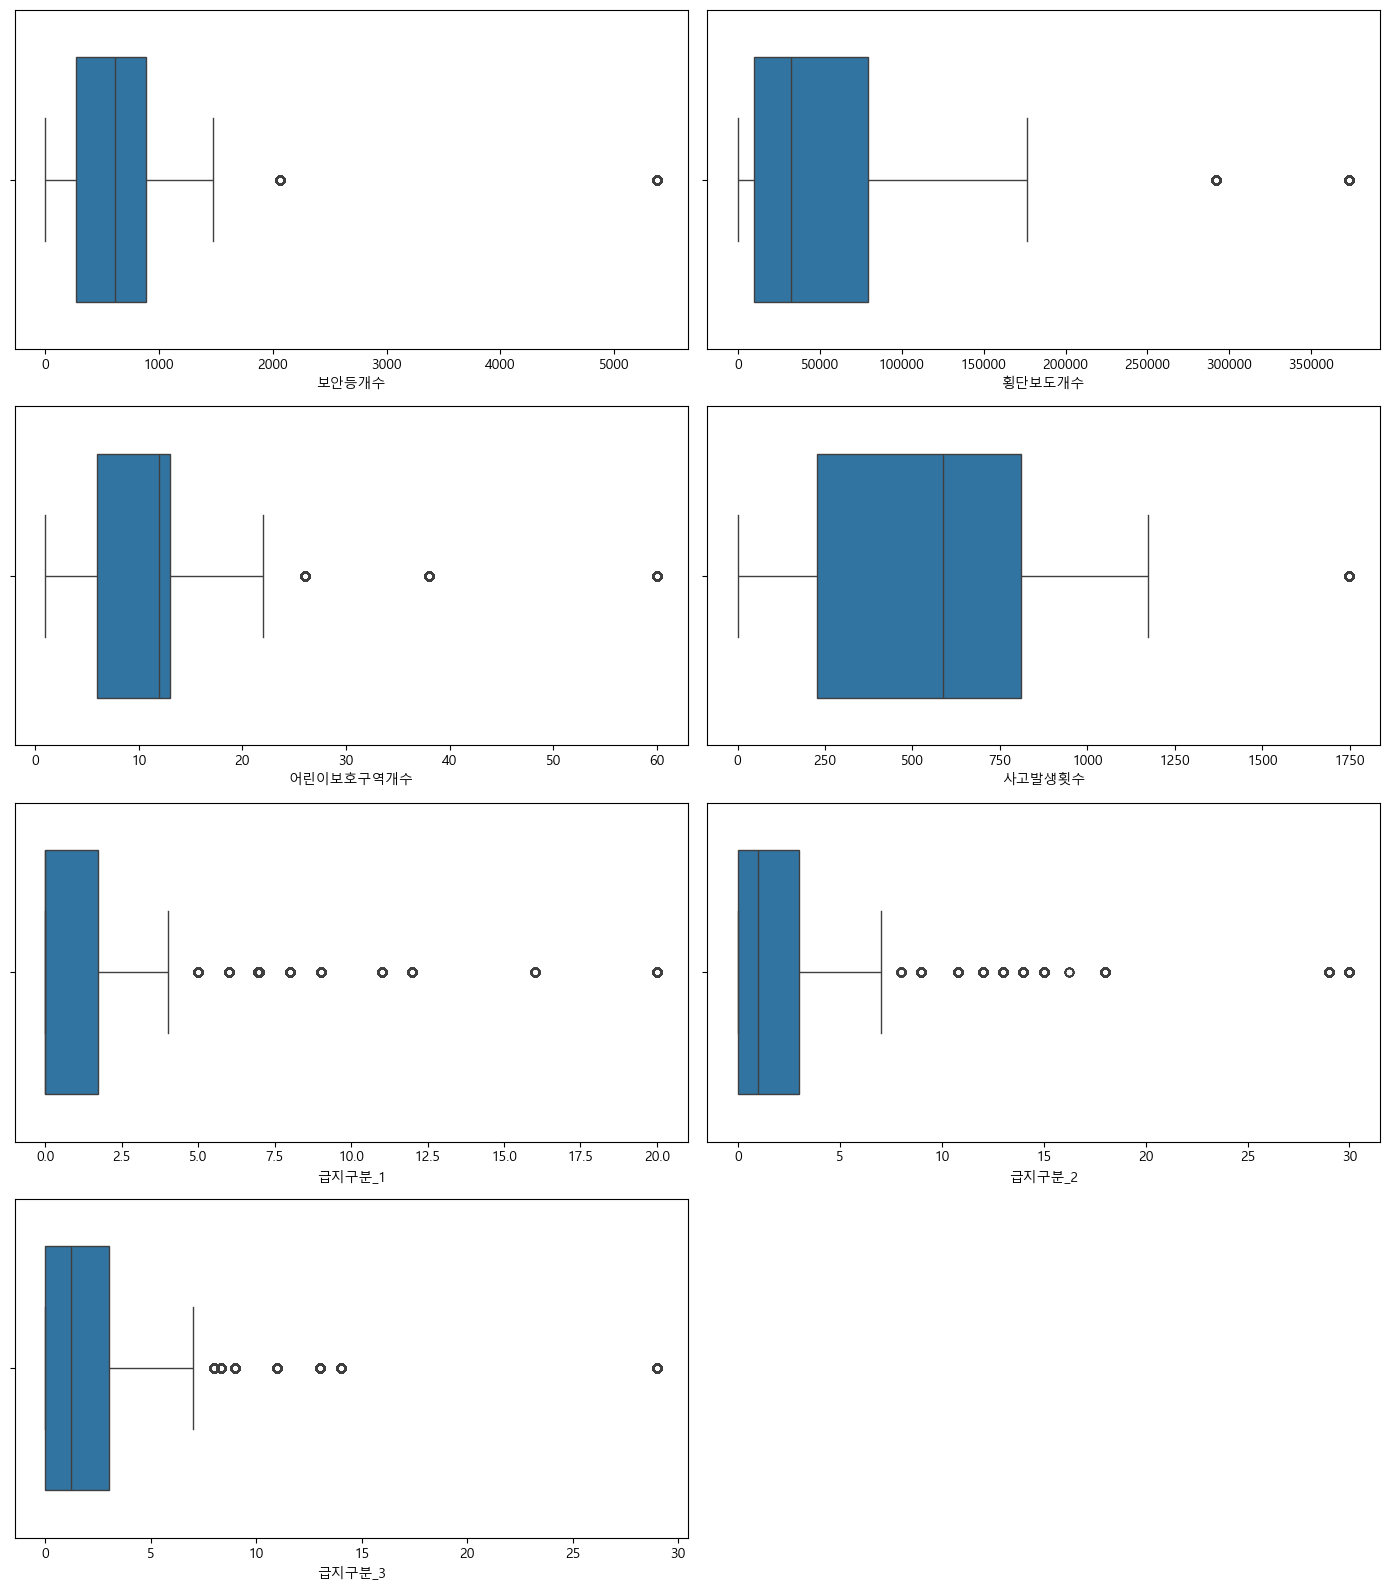

In [18]:
### 이상치 처리 시각화 코드 무지성 boxplot
i = 0 
outlier_columns = ['보안등개수','횡단보도개수','어린이보호구역개수',
           '사고발생횟수','급지구분_1','급지구분_2','급지구분_3'] # 확인하고픈 수치형 컬럼 넣기
sub_cols = 2
sub_rows = (len(outlier_columns)+1) // 2
width = len(outlier_columns) * 2 ### width, height 곱하는 숫자 조정해서 플롯 사이즈 조정
height = sub_rows * 4

plt.figure(figsize=(width, height)) # figure의 width height는 맘대로
for col in outlier_columns:
    i += 1
    plt.subplot(sub_rows,sub_cols,i)
    sns.boxplot(data=train_df,x=col,gap=.1)
#     plt.xticks(rotation=45)
plt.tight_layout()

In [19]:
### 이상치 처리 함수 정의
import numpy as np
def tukey_fences(data): # data는 1차원 배열
    q1,q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lf = q1 - (iqr*1.5)
    uf = q3 + (iqr*1.5)
    idxs = np.where((data>uf) | (data<lf))[0] # condition이 True일 때, data의 인덱스를 반환
    return idxs, lf, uf

def outlier_to_lf_uf(data, outlier_function=tukey_fences): # data는 Series객체
    idxs, lf, uf = outlier_function(data)
    for i in idxs:
        if data.iloc[i] <= lf:
            data.iloc[i] = lf
        elif data.iloc[i] >= uf:
            data.iloc[i] = uf
            
    return data

In [20]:
train_df.columns

Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '구', '동',
       'cos_hour', 'holiday', 'season', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3',
       '제한속도', '횡단보도개수', '어린이보호구역개수', '사고발생횟수'],
      dtype='object')

In [21]:
### 이상치 처리 수행
for col in outlier_columns:
    train_df[col] = outlier_to_lf_uf(train_df[col], tukey_fences)
    test_df[col] = outlier_to_lf_uf(test_df[col], tukey_fences)

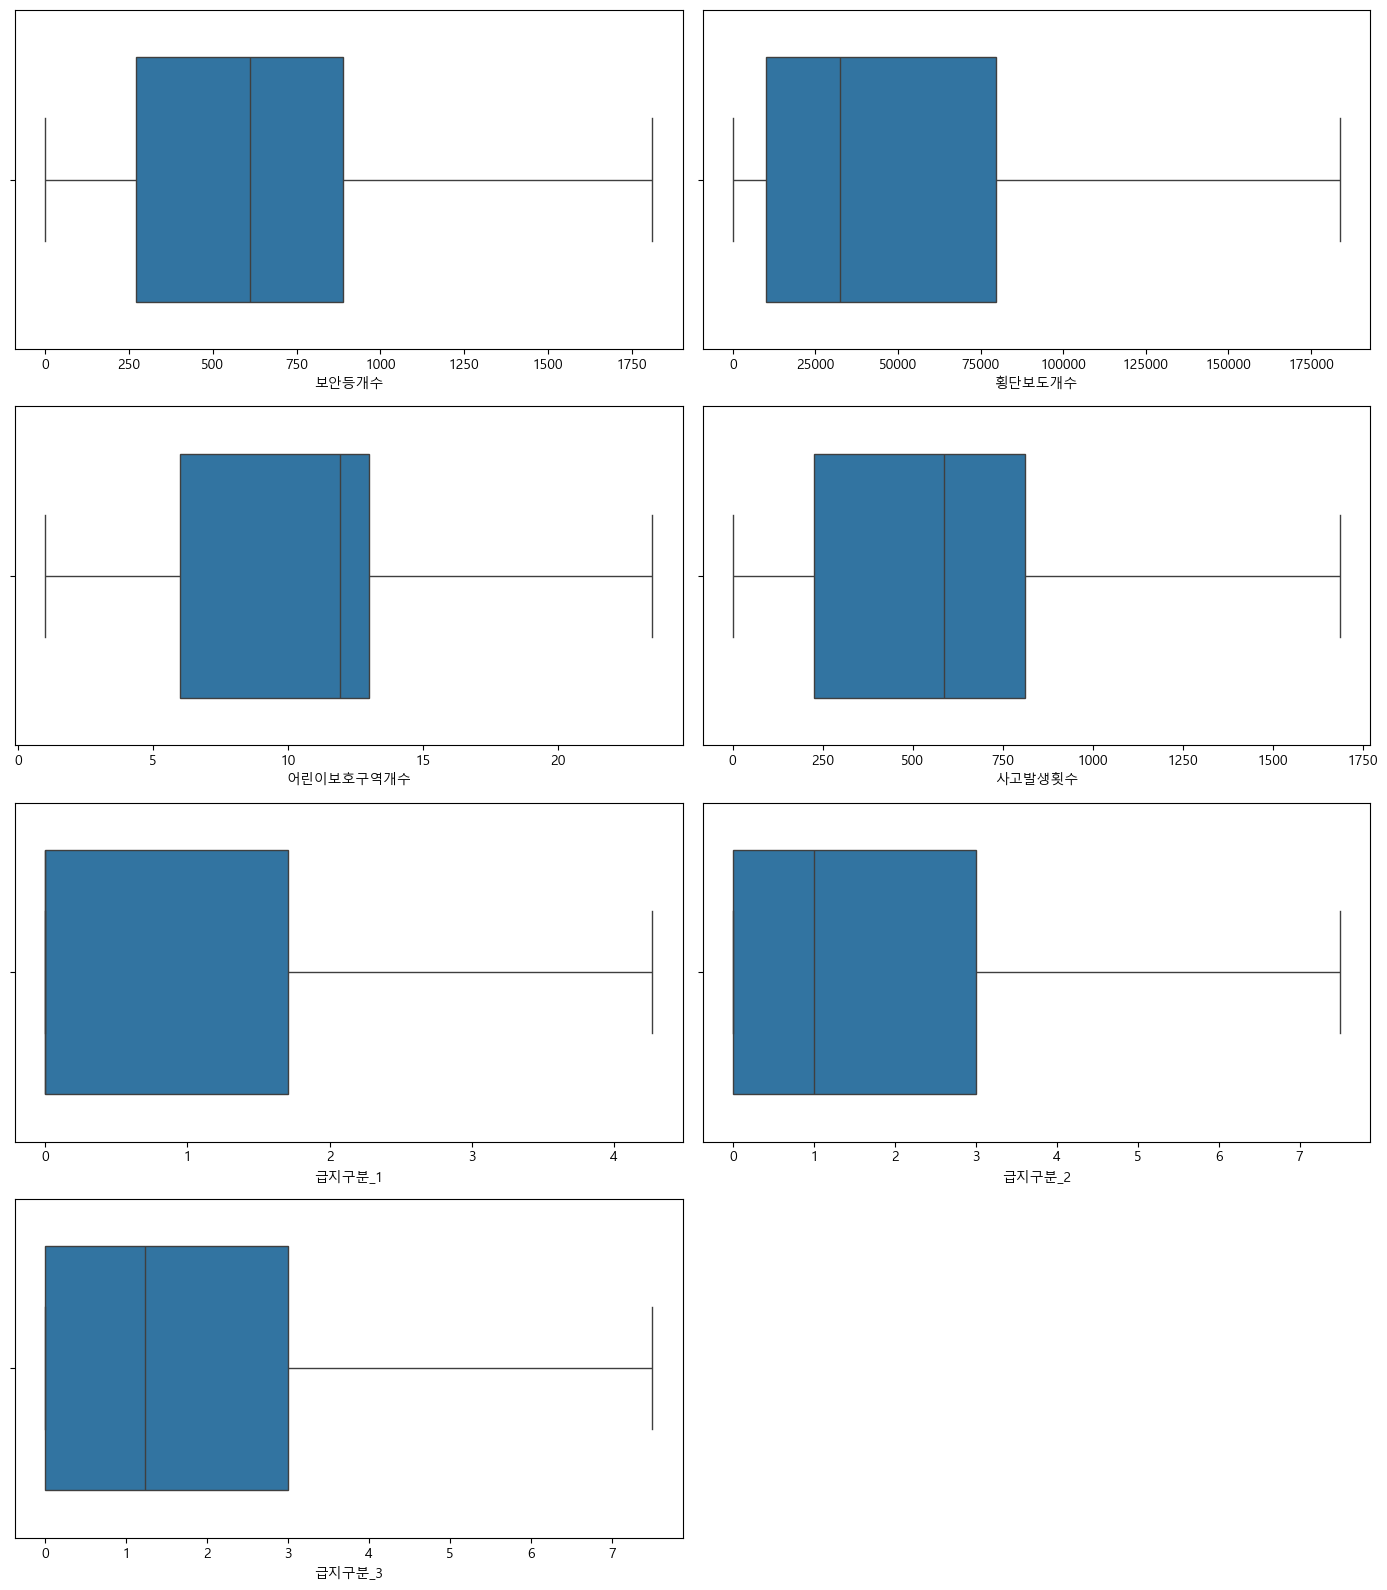

In [22]:
### 이상치 처리가 완료된 데이터 시각화
i = 0 

sub_cols = 2
sub_rows = (len(outlier_columns)+1) // 2
width = len(outlier_columns) * 2 ### width, height 곱하는 숫자 조정해서 플롯 사이즈 조정
height = sub_rows * 4

plt.figure(figsize=(width, height)) # figure의 width height는 맘대로
for col in outlier_columns:
    i += 1
    plt.subplot(sub_rows,sub_cols,i)
    sns.boxplot(data=train_df,x=col,gap=.1)
#     plt.xticks(rotation=45)
plt.tight_layout()

In [23]:
train_df.columns

Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '구', '동',
       'cos_hour', 'holiday', 'season', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3',
       '제한속도', '횡단보도개수', '어린이보호구역개수', '사고발생횟수'],
      dtype='object')

### 인코딩 및 스케일링

In [24]:
# 원핫 : 사고유형, 도로형태, 동

onehot_columns = ['사고유형', '도로형태', '동']

# train_df와 test_df의 기상상태 및 노면상태 열 선택
train_categorical_data = train_df[onehot_columns]
test_categorical_data = test_df[onehot_columns]

# OneHotEncoder 인스턴스 생성 및 fit_transform 수행
encoder = OneHotEncoder()
train_encoded = encoder.fit_transform(train_categorical_data)
test_encoded = encoder.transform(test_categorical_data)

# OneHotEncoder가 사용한 카테고리 목록을 가져와서 카테고리 이름을 열 이름으로 변환
feature_names = encoder.get_feature_names_out(onehot_columns)

# 밀집 행렬로 변환 (선택 사항)
train_encoded_dense = train_encoded.toarray()
test_encoded_dense = test_encoded.toarray()

# 데이터프레임으로 변환 (선택 사항)
import pandas as pd

train_encoded_df = pd.DataFrame(train_encoded_dense, columns=feature_names, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded_dense, columns=feature_names, index=test_df.index)

### PCA 
pca = PCA(n_components=98)
train_encoded_df_pca = pd.DataFrame(pca.fit_transform(train_encoded_df))
test_encoded_df_pca = pd.DataFrame(pca.transform(test_encoded_df))

new_col_list = list(map(lambda x:'pca_'+str(x),[i for i in range(98)]))
old_col_list = [i for i in range(98)]
rename_dict = dict(zip(old_col_list, new_col_list))
train_encoded_df_pca.rename(columns=rename_dict,inplace=True)
test_encoded_df_pca.rename(columns=rename_dict,inplace=True)

# 기존 열 제거
train_df = train_df.drop(onehot_columns, axis=1)
test_df = test_df.drop(onehot_columns, axis=1)

# 인코딩된 열 추가
train_df = pd.concat([train_df, train_encoded_df_pca], axis=1)
test_df = pd.concat([test_df, test_encoded_df_pca], axis=1)


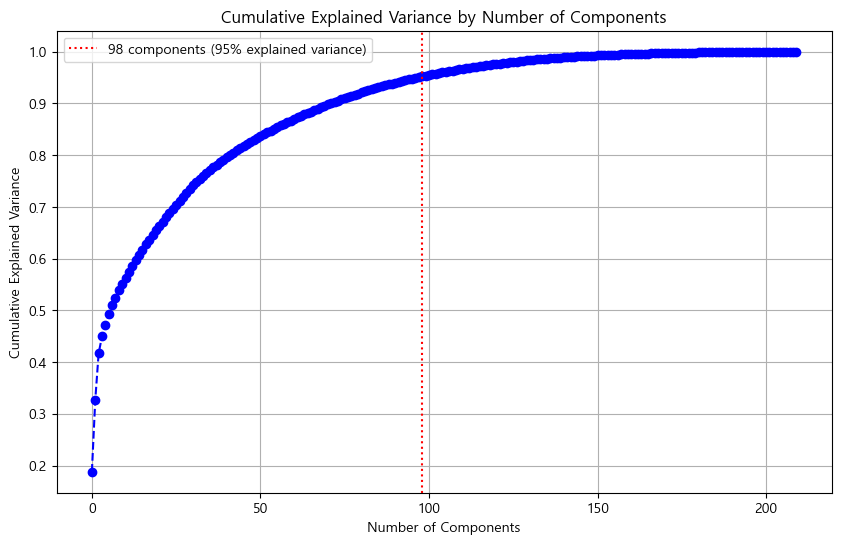

95% 이상의 설명력을 갖기 위해 98개의 주성분으로 나누어야 합니다.


In [25]:
pca_practice = PCA()
X = train_encoded_df.copy()
pca_practice.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca_practice.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"95% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")


In [26]:
# 타겟 인코딩 : '요일', '기상상태', '노면상태', '연', '구', season
#        
# Target encoding
from category_encoders.target_encoder import TargetEncoder

### ✔️ 타겟 인코딩하기 전에 eclo 로그 변환해주기
train_df['ECLO'] = np.log1p(train_df['ECLO'])

categorical_features = ['요일', '기상상태', '노면상태', '연', '구','season']

for i in categorical_features:
    tr_encoder = TargetEncoder(cols=[i])
    train_df[i] = tr_encoder.fit_transform(train_df[i], train_df['ECLO'])
    test_df[i] = tr_encoder.transform(test_df[i])

In [27]:

train_df

,요일,기상상태,노면상태,ECLO,연,월,일,구,cos_hour,holiday,season,보안등개수,급지구분_1,급지구분_2,급지구분_3,제한속도,횡단보도개수,어린이보호구역개수,사고발생횟수,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97
0,1.620570,1.632169,1.6324,1.791759,1.647741,1,1,1.591413,2.000000,1,1.62722,391.000000,4.269363,0.000000,0.000000,8.000000,5929.0,2.000000,131,1.028394,0.744103,-0.153977,-0.161844,-0.035476,-0.046011,-0.121634,-0.012007,-0.025361,-0.015198,-0.010834,-0.005507,-0.009992,-0.022726,-0.008522,-0.021876,-0.009645,-0.027244,-0.003563,-0.007166,-0.010681,-0.005871,-0.001079,0.000745,0.006691,0.009461,-0.002398,0.006288,0.005300,0.001080,0.022400,0.034125,-0.033686,0.002278,-0.017559,-0.001208,-0.019376,-0.007571,-0.018434,-0.023665,-0.019851,-0.011740,-0.001813,0.003782,0.009751,0.023452,-0.015794,0.021207,-0.016711,-0.007529,-0.009163,0.007693,0.005026,0.008810,0.007628,0.020719,0.006619,0.022679,-0.017069,-0.011919,0.000146,0.007622,0.006902,0.014472,0.018485,0.020998,0.000777,0.014177,-0.008665,0.002471,0.010447,0.019629,0.039354,0.001400,0.024378,0.036341,-0.024417,0.004590,0.005446,0.006657,0.021710,0.024511,0.084254,0.000283,0.032157,0.047754,0.048331,0.016488,0.019452,0.173174,0.873030,-0.397797,-0.036519,-0.034780,0.053099,-0.033739,-0.006207,-0.013588
1,1.620570,1.644549,1.6324,1.386294,1.647741,1,1,1.626681,2.000000,1,1.62722,941.000000,0.000000,1.000000,3.000000,17.500000,10000.0,11.917411,678,1.030433,0.739078,-0.152919,-0.149887,-0.052126,-0.049852,-0.128163,-0.023888,-0.051951,-0.028921,-0.027383,-0.025221,-0.015671,-0.068960,-0.035276,-0.055062,-0.043319,-0.170926,-0.179742,-0.444751,0.748039,0.351976,0.025529,0.028642,0.027957,-0.027267,-0.032293,-0.029730,-0.024361,-0.027907,-0.036309,-0.081358,0.036931,0.029155,0.031782,0.020742,0.015411,0.008276,0.024936,0.007381,0.005580,0.012080,0.001938,-0.006578,-0.000683,-0.013666,0.003329,-0.007135,0.005012,0.003639,0.003308,-0.000575,-0.003139,-0.001510,-0.001278,-0.008136,-0.000453,-0.008433,0.006540,-0.005316,-0.005910,-0.013770,0.012793,0.010402,0.003803,0.008266,-0.007785,0.003262,0.000480,0.004744,0.000461,0.002354,-0.000940,0.000596,-0.005926,-0.006791,-0.000085,0.001762,-0.000930,-0.002566,-0.000090,0.000058,-0.002229,0.004159,-0.000656,-0.005401,0.003597,0.000274,-0.002985,-0.000680,-0.004926,-0.001337,-0.001695,-0.000622,-0.000968,-0.001269,-0.002009,0.001831
2,1.620570,1.632169,1.6324,1.386294,1.647741,1,1,1.639076,3.831951,1,1.62722,473.000000,0.316389,1.356052,1.110554,55.000000,14641.0,5.000000,604,1.028255,0.740504,-0.154713,-0.155800,-0.048561,-0.049895,-0.130639,-0.020823,-0.044820,-0.024774,-0.022310,-0.017875,-0.013997,-0.051956,-0.022645,-0.041514,-0.027233,-0.093548,-0.043927,-0.044299,-0.053900,-0.111698,-0.040271,-0.045320,-0.038667,0.116501,0.140451,0.793288,-0.452255,-0.165549,-0.116081,-0.146493,0.066648,0.028527,0.039582,0.016523,0.022299,0.009082,0.026626,0.016497,0.008625,0.013843,0.001234,-0.008355,-0.001740,-0.016400,0.002074,-0.011733,0.007410,0.004046,0.002870,-0.002437,-0.004683,-0.003078,0.004338,-0.009530,-0.000580,-0.009690,0.005746,-0.007810,-0.008708,-0.017020,0.014219,0.010990,0.001155,0.008015,-0.009012,0.002689,0.001520,0.005376,0.001164,0.002469,-0.001340,0.000547,-0.006679,-0.007469,0.000101,0.001845,-0.000648,-0.002654,-0.000561,-0.000078,-0.003184,0.004277,-0.000869,-0.005912,0.003937,0.000255,-0.003062,-0.000891,-0.005320,-0.002036,-0.001723,-0.000741,-0.00098

In [28]:
# 스케일링 전 전처리
# 일 필요 없을 듯?
# train_df.drop(columns=['일'],inplace=True)
# test_df.drop(columns=['일'],inplace=True)

In [29]:
# # 스케일링 전 분포 시각화
# i = 0 
# columns = train_df.columns
# sub_cols = 2
# sub_rows = (len(columns)+1) // 2
# width = len(columns)
# height = sub_rows * 8

# plt.figure(figsize=(width, height)) # figure의 width height는 맘대로
# for col in columns:
#     i += 1
#     plt.subplot(sub_rows,sub_cols,i)
#     sns.histplot(data=train_df,x=col,kde=True)
# plt.tight_layout()

In [30]:
train_df.columns

Index(['요일', '기상상태', '노면상태', 'ECLO', '연', '월', '일', '구', 'cos_hour', 'holiday',
       ...
       'pca_88', 'pca_89', 'pca_90', 'pca_91', 'pca_92', 'pca_93', 'pca_94',
       'pca_95', 'pca_96', 'pca_97'],
      dtype='object', length=117)

In [31]:
### 스케일링
# scaling_columns = [
# #     '요일', '기상상태', '도로형태', '노면상태', '사고유형', 
# #    '연','동','cos_hour','cos_month',
#    '보안등개수','어린이보호구역개수',
#    '사고발생횟수',
#     '제한속도','주차장지수','횡단보도개수'
# ]

# log_scaling_columns = ['주차장지수','제한속도','횡단보도개수'] # ECLO는 이미 로그변환 완료

# for c in log_scaling_columns:
#     train_df[c] = np.log1p(train_df[c])
#     test_df[c] = np.log1p(test_df[c])

# mms = MinMaxScaler()
# ssc = StandardScaler()
# for c in scaling_columns: #+log_scaling_columns:
#     train_df[c] = ssc.fit_transform(np.reshape(train_df[c],(-1,1)))
#     test_df[c] = ssc.transform(np.reshape(test_df[c],(-1,1)))

In [32]:
# # 스케일링 후 분포 시각화
# i = 0 
# columns = train_df.columns
# sub_cols = 2
# sub_rows = (len(columns)+1) // 2
# width = len(columns)
# height = sub_rows * 8

# plt.figure(figsize=(width, height)) # figure의 width height는 맘대로
# for col in columns:
#     i += 1
#     plt.subplot(sub_rows,sub_cols,i)
#     sns.histplot(data=train_df,x=col,kde=True)
# plt.tight_layout()

### 기타 전처리

In [33]:
train_df

,요일,기상상태,노면상태,ECLO,연,월,일,구,cos_hour,holiday,season,보안등개수,급지구분_1,급지구분_2,급지구분_3,제한속도,횡단보도개수,어린이보호구역개수,사고발생횟수,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97
0,1.620570,1.632169,1.6324,1.791759,1.647741,1,1,1.591413,2.000000,1,1.62722,391.000000,4.269363,0.000000,0.000000,8.000000,5929.0,2.000000,131,1.028394,0.744103,-0.153977,-0.161844,-0.035476,-0.046011,-0.121634,-0.012007,-0.025361,-0.015198,-0.010834,-0.005507,-0.009992,-0.022726,-0.008522,-0.021876,-0.009645,-0.027244,-0.003563,-0.007166,-0.010681,-0.005871,-0.001079,0.000745,0.006691,0.009461,-0.002398,0.006288,0.005300,0.001080,0.022400,0.034125,-0.033686,0.002278,-0.017559,-0.001208,-0.019376,-0.007571,-0.018434,-0.023665,-0.019851,-0.011740,-0.001813,0.003782,0.009751,0.023452,-0.015794,0.021207,-0.016711,-0.007529,-0.009163,0.007693,0.005026,0.008810,0.007628,0.020719,0.006619,0.022679,-0.017069,-0.011919,0.000146,0.007622,0.006902,0.014472,0.018485,0.020998,0.000777,0.014177,-0.008665,0.002471,0.010447,0.019629,0.039354,0.001400,0.024378,0.036341,-0.024417,0.004590,0.005446,0.006657,0.021710,0.024511,0.084254,0.000283,0.032157,0.047754,0.048331,0.016488,0.019452,0.173174,0.873030,-0.397797,-0.036519,-0.034780,0.053099,-0.033739,-0.006207,-0.013588
1,1.620570,1.644549,1.6324,1.386294,1.647741,1,1,1.626681,2.000000,1,1.62722,941.000000,0.000000,1.000000,3.000000,17.500000,10000.0,11.917411,678,1.030433,0.739078,-0.152919,-0.149887,-0.052126,-0.049852,-0.128163,-0.023888,-0.051951,-0.028921,-0.027383,-0.025221,-0.015671,-0.068960,-0.035276,-0.055062,-0.043319,-0.170926,-0.179742,-0.444751,0.748039,0.351976,0.025529,0.028642,0.027957,-0.027267,-0.032293,-0.029730,-0.024361,-0.027907,-0.036309,-0.081358,0.036931,0.029155,0.031782,0.020742,0.015411,0.008276,0.024936,0.007381,0.005580,0.012080,0.001938,-0.006578,-0.000683,-0.013666,0.003329,-0.007135,0.005012,0.003639,0.003308,-0.000575,-0.003139,-0.001510,-0.001278,-0.008136,-0.000453,-0.008433,0.006540,-0.005316,-0.005910,-0.013770,0.012793,0.010402,0.003803,0.008266,-0.007785,0.003262,0.000480,0.004744,0.000461,0.002354,-0.000940,0.000596,-0.005926,-0.006791,-0.000085,0.001762,-0.000930,-0.002566,-0.000090,0.000058,-0.002229,0.004159,-0.000656,-0.005401,0.003597,0.000274,-0.002985,-0.000680,-0.004926,-0.001337,-0.001695,-0.000622,-0.000968,-0.001269,-0.002009,0.001831
2,1.620570,1.632169,1.6324,1.386294,1.647741,1,1,1.639076,3.831951,1,1.62722,473.000000,0.316389,1.356052,1.110554,55.000000,14641.0,5.000000,604,1.028255,0.740504,-0.154713,-0.155800,-0.048561,-0.049895,-0.130639,-0.020823,-0.044820,-0.024774,-0.022310,-0.017875,-0.013997,-0.051956,-0.022645,-0.041514,-0.027233,-0.093548,-0.043927,-0.044299,-0.053900,-0.111698,-0.040271,-0.045320,-0.038667,0.116501,0.140451,0.793288,-0.452255,-0.165549,-0.116081,-0.146493,0.066648,0.028527,0.039582,0.016523,0.022299,0.009082,0.026626,0.016497,0.008625,0.013843,0.001234,-0.008355,-0.001740,-0.016400,0.002074,-0.011733,0.007410,0.004046,0.002870,-0.002437,-0.004683,-0.003078,0.004338,-0.009530,-0.000580,-0.009690,0.005746,-0.007810,-0.008708,-0.017020,0.014219,0.010990,0.001155,0.008015,-0.009012,0.002689,0.001520,0.005376,0.001164,0.002469,-0.001340,0.000547,-0.006679,-0.007469,0.000101,0.001845,-0.000648,-0.002654,-0.000561,-0.000078,-0.003184,0.004277,-0.000869,-0.005912,0.003937,0.000255,-0.003062,-0.000891,-0.005320,-0.002036,-0.001723,-0.000741,-0.00098

In [34]:
# train_df.to_csv('./train_df.csv',index=False)
# test_df.to_csv('./test_df.csv',index=False)

### 데이터셋 분할

In [35]:
train_df.head(1)

,요일,기상상태,노면상태,ECLO,연,월,일,구,cos_hour,holiday,season,보안등개수,급지구분_1,급지구분_2,급지구분_3,제한속도,횡단보도개수,어린이보호구역개수,사고발생횟수,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97
0,1.62057,1.632169,1.6324,1.791759,1.647741,1,1,1.591413,2.0,1,1.62722,391.0,4.269363,0.0,0.0,8.0,5929.0,2.0,131,1.028394,0.744103,-0.153977,-0.161844,-0.035476,-0.046011,-0.121634,-0.012007,-0.025361,-0.015198,-0.010834,-0.005507,-0.009992,-0.022726,-0.008522,-0.021876,-0.009645,-0.027244,-0.003563,-0.007166,-0.010681,-0.005871,-0.001079,0.000745,0.006691,0.009461,-0.002398,0.006288,0.0053,0.00108,0.0224,0.034125,-0.033686,0.002278,-0.017559,-0.001208,-0.019376,-0.007571,-0.018434,-0.023665,-0.019851,-0.01174,-0.001813,0.003782,0.009751,0.023452,-0.015794,0.021207,-0.016711,-0.007529,-0.009163,0.007693,0.005026,0.00881,0.007628,0.020719,0.006619,0.022679,-0.017069,-0.011919,0.000146,0.007622,0.006902,0.014472,0.018485,0.020998,0.000777,0.014177,-0.008665,0.002471,0.010447,0.019629,0.039354,0.0014,0.024378,0.036341,-0.024417,0.00459,0.005446,0.006657,0.02171,0.024511,0.084254,0.000283,0.032157,0.047754,0.048331,0.016488,0.019452,0.173174,0.87303,-0.397797,-0.036519,-0.03478,0.053099,-0.033739,-0.006207,-0.013588


In [36]:
# 컬럼명 영어로 바꾸기
kr2eng = {'요일':'dayofweek', '기상상태':'weather', '도로형태':'road_type',
          '노면상태':'road_state', '사고유형':'accident_type', '연':'year',
          '동':'dong', '보안등개수':'light_count', '제한속도':'speed_limit',
          '횡단보도개수':'cross_count', '어린이보호구역개수':'child_count',
          '사고발생횟수':'accident_count', '주차장지수':'parking_index',
          '구_남구':'gu_namgu', '구_달서구':'gu_dalseogu', 
          '구_달성군':'gu_dalsunggun', '구_동구':'gu_donggu', 
          '구_북구':'gu_bookgu', '구_서구':'gu_seogu',
       '구_수성구':'gu_suseonggu', '구_중구':'gu_junggu',
         '월':'month','일':'day','구':'gu',
         '급지구분':'park_1','급지구분_2':'park_2','급지구분_3':'park_3'}

train_df.rename(columns=kr2eng,inplace=True)
test_df.rename(columns=kr2eng,inplace=True)

In [37]:
train_x = train_df[test_df.columns] # test 셋에만 있는 컬럼만 추출
train_y = train_df['ECLO']
test_x = test_df

In [38]:
# x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

### AUTOML

In [39]:
import matplotlib
matplotlib.use('Agg')

In [43]:
from supervised.automl import AutoML
automl = AutoML(
                algorithms = ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1,total_time_limit=40000, eval_metric="rmse", ml_task = "regression",
               results_path = './AutoML_005_Compete/',
                explain_level=2,
                mode='Compete',
                random_state=42,
                stack_models=True
               )

In [44]:
automl.fit(train_x, train_y)

AutoML directory: ./AutoML_005_Compete/
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree rmse 0.445888 trained in 46.02 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 4 models
1_Default_LightGBM rmse 0.445348 trained in 139.5 seconds
2_Default_Xgboost rmse 0.445289 trained in 108.42 seconds
3_Default_CatBoost rmse 0.444789 trained in 41.56 seconds

16_LightGBM_Stacked rmse 0.444953 trained in 94.32 seconds
67_Xgboost_Stacked rmse 0.444741 trained in 104.96 seconds
68_RandomForest_Stacked rmse 0.444653 trained in 444.22 seconds
3_Default_CatBoost_GoldenFeatures_Stacked rmse 0.44468 trained in 48.62 seconds
15_LightGBM_Stacked rmse 0.444807 trained in 86.77 seconds
8_Xgboost_Stacked rmse 0.444993 trained in 100.94 seconds
55_RandomForest_Stacked rmse 0.444722 trained in 415.45 seconds
62_CatBoost_GoldenFeatures_Stacked rmse 0.444742 trained in 63.76 seconds
16_LightGBM_GoldenFeatures_SelectedFeatures_Stacked rmse 0.444768 trained in 65.42 seconds
53_Xgboost_SelectedFeatures_Stacked rmse 0.444852 trained in 62.82 seconds
69_RandomForest_Stacked rmse 0.444737 trained in 643.35 seconds
60_CatBoost_Stacked rmse 0.444722 trained in 60.59 seconds
50_LightGBM_Stacked rmse 0.444907 trained in 92.62 seconds
10_Xgboost_Stacked rmse 0.444971 trained in 104.59 seconds
38_RandomForest_Stacked rmse 0.444704 trained in 609.07 seconds
65_CatBoost_

AutoML(algorithms=['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost'],
       eval_metric='rmse', explain_level=2, ml_task='regression',
       mode='Compete', random_state=42, results_path='./AutoML_005_Compete/',
       stack_models=True, total_time_limit=40000)

In [45]:
pred = automl.predict(test_x)

## 제출

In [46]:
submission = pd.read_csv(path+'sample_submission.csv')

In [47]:
submission['ECLO'] = np.expm1(pred)

In [48]:
submission.loc[ submission['ECLO'] < 0.0, 'ECLO'] = 0.0

In [49]:
min(submission['ECLO'])

2.9228105083782485

In [50]:
max(submission['ECLO'])

5.870360969892211

In [51]:
submission

,ID,ECLO
0,ACCIDENT_39609,3.917333
1,ACCIDENT_39610,3.629984
2,ACCIDENT_39611,4.920436
3,ACCIDENT_39612,4.279934
4,ACCIDENT_39613,4.623001
...,...,...
10958,ACCIDENT_50567,5.258753
10959,ACCIDENT_50568,4.466652
10960,ACCIDENT_50569,4.598511
10961,ACCIDENT_50570,4.607878


In [52]:
submission.to_csv('submit.csv', index=False)

submit_path = "../data/submits/automl_1209_005_Compete.csv"
submission.to_csv(submit_path, index=False)

In [53]:
# 데이콘 api 제출

from dacon_submit_api import dacon_submit_api

result = dacon_submit_api.post_submission_file(
  submit_path,  # 제출 파일의 저장경로
  '99e503e9d7311db9f4167d982d5823d7ef9427cc628aa63b96cf79d2920ba916', # API 토큰
  '236193', # 대구공모전 ID
  'song999', # 맘대루
  '12.09 - 005. automl_compete' )  # 제출 메모

{'isSubmitted': True, 'detail': 'Success'}
